  The purpose of this notebook is to present programming solutions to two parameter estimation problems using Expectation Maximization. It will focus on code and results, with some discussion of the underlying mathematics.<br/>
  The first problem we will tackle is the three coin problem. Consider three wieghted coins, with unknown weights l, p, and q. The first coin is flipped. If it is heads, the second coin is flipped three times; otherwise the third coin is flipped three times. Given only the result of flipping the second or third coin three times, and not the result of flipping the first coin, we would like to estimate the weights of all three coins. Supposing this process is repeated many times, sample output could look like this:<br/>
  TTT<br/>
  HTH<br/>
  THH<br/>
  HTT<br/>
  ...<br/>
  HHH<br/>
  HTT<br/>
  The issue is that we do not know which coin produced which output. Solving this problem requires a degree of mathematical sophistication. First, we introduce some notation.<br/> <br/>
  Suppose we have the results of n trials. Let $x_i$ denote the number of heads observed in the n-th trial. Let $\theta = (l, p, q)$ denote the parameters of the coins. We seek to find the parameters that maximize the likelihood of observing the data. We then seek $$\theta_{best} = argmax_{\theta} \prod_{i=1}^{i=n}P(x_i|\theta)$$
  
  After taking logs, and applying the famous Expectation Maximization algorithm, we arrive at the following updates for l, p and q.
  
   $$\mu_i = \frac{l(p)^{x_i}(1-p)^{3-x_i}}{l(p)^{x_i}(1-p)^{3-x_i} + (1-l)(q)^{x_i}(1-q)^{3-x_i}}$$</br>
  
  $$l = \frac{1}{n}\sum_{i=1}^{i=n}\mu_i$$<br/>
  $$p = \frac{1}{\sum_{i=1}^{i=n}3\mu_i}\sum_1^nx_{i}\mu_{i}$$
  $$q = \frac{1}{\sum_{i=1}^{i=n}3(1-\mu_i)}\sum_{i=1}^{i=n}x_{i}(1-\mu_{i})$$
  
  Note this method requires an initial guess for l, p and q.
  

To test an implementation of the EM algorithm for this problem, we need to have some type of synthetic data to run the algorithm on. The following code generates synthetic data given secret values of l, p and q.

In [ ]:
#three coins problem
def gen_coin_data(theta, num_samples):
 data = np.empty(num_samples,dtype = int)
 for i in xrange(num_samples):
  if np.random.rand() < theta[0]:
   data[i] = np.random.binomial(3,theta[1])
  else:
   data[i] = np.random.binomial(3,theta[2])
 return data



The following code uses Expectation Maximization to recover the coin weights. Although this method is reasonably accurate, it is quite slow, and can be made much faster. 

In [27]:
secret_theta = [.5, .1, .7]
data = gen_coin_data(secret_theta,20000)

#do EM
def solve_tri_coin(theta, data, iterations = 500):
 n = data.size
 for i in xrange(iterations):
  l, p1, p2 = theta
  temp1 = l * p1**data * (1-p1) ** (3-data)
  temp2 = (1-l)* p2 ** data * (1-p2) ** (3-data)
  mu = temp1/(temp1 + temp2)
  musum = np.sum(mu)
  l = musum / n
  p1 = 1/musum * 1./3 * np.dot(data, mu)
  p2 = 1/(n-musum) * 1./3 * np.dot(data, 1-mu)
  theta_new = [l, p1, p2]
  if sum([abs(theta[j]-theta_new[j]) for j in xrange(len(theta))]) < 1e-10:
    return theta_new
  theta = theta_new
 return theta

print "Secret Parameters: ",secret_theta
print "Reconstructed paramters", solve_tri_coin([.5,.51,.52], data)

Secret Parameters:  [0.5, 0.1, 0.7]
Reconstructed paramters [0.51417776835171713, 0.10937623897551008, 0.71074249050870753]


Note that given l, p, and q, $\mu_i$ only depends on $x_i$, the number of heads in the i-th experiment. As there are only 4 possibilities for $x_i$, many values of $\mu_i$ are duplicate. The above code recomputes these values thousands of times over. The below code avoids such duplication and is many times faster. It does not require an initial guess, but instead tries a large number of random initial guesses and choses the most likely one. This approach avoids local minima and therefore improves accuracy.

In [16]:
secret_theta = [.6, .1, .7]
data = gen_coin_data(secret_theta,20000)


#Probability density function for bernoulli distribution with 3 trials
P = lambda p, heads: (p)**heads*(1-p)**(3-heads) 

def tri_coin_likelihood(theta, data):
  l, p, q = theta[0], theta[1], theta[2]
  likelihood = 0
  for heads in xrange(len(data)):
   likelihood += data[heads] * np.log(l * P(p,heads) + (1-l) * P(q,heads))
  return likelihood
  
def faster_tri_coin(theta, data, max_iters = 500):
  heads = np.arange(4)
  n = np.sum(data)
  for _ in xrange(max_iters):
   l, p, q = theta[0], theta[1], theta[2]
   t1, t2 = l*P(p, heads), (1-l)*P(q, heads)
   mu = data * t1/(t1 + t2)
   musum = np.sum(mu)
   l = musum / n
   p = np.dot(heads, mu)/ (3*musum)
   q = np.dot(heads, data-mu) / (3 *(n-musum))
   theta = np.array([l, p, q])
  return theta
def smarter_tri_coin(data, nguesses = 50, max_iters = 100):
  #We count the number of occurences of each number of heads
  d = np.bincount(data)
  maxl = -np.inf
  best_theta = None
  for _ in xrange(nguesses):
    theta = np.random.random(3)
    theta = faster_tri_coin(theta, d, max_iters)
    likelihood = tri_coin_likelihood(theta, d)
    if likelihood > maxl:
     maxl = likelihood
     best_theta = theta
  return best_theta
 

print "Secret Parameters", secret_theta
print "Recovered Parameters", smarter_tri_coin(data,nguesses=100, max_iters = 100)


Secret Parameters [0.6, 0.1, 0.7]
Recovered Parameters [ 0.61342041  0.10530855  0.71046583]


The second problem we'll consider is the Gaussian micture model problem. Given an unknown probability distribution with density function D, we seek to write D as a convex combination of Gaussian density function. Formally, we seek $\lambda$'s, $\mu$'s, and $\sigma$'s such that: $$D(x) = \sum_{i=1}^{i=k}\lambda_iP(X_i=x)$$
where $X_i$ is normally distributed with mean $\mu_i$ and variance $\sigma_i^2$. This problem can be solved using Expectation Maximization. As with the three coin problem, an initial guess for all parameters is required, and we obtain update formulas for all of the paramters. I will omit these update formulas for the sake of brevity, but they can be found in <a href="http://www.cs.huji.ac.il/~shashua/papers/class4-5-EM.pdf">this paper</a>, and are implemented below.

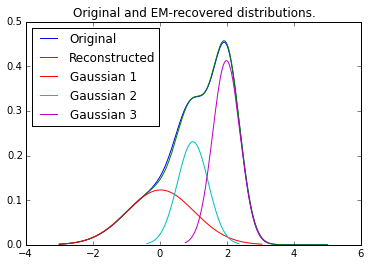

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt



def plot_gaussian_mixture(l, m ,s, legend=None):
 n = len(l)
 max_sigma = max(s)
 x = np.linspace(max(m)+3*max_sigma,min(m) - 3*max_sigma,300)
 y = np.zeros(x.size)
 for i in xrange(n):
  y += l[i] * np.exp(-((x-m[i])/(np.sqrt(2)*s[i]))**2 ) / (s[i] * (2*np.pi)**.5)
 plt.plot(x,y, label = legend)
 


def gaussian_data(lambdas, mus, sigmas, npoints):
 data = np.zeros(npoints)
 if abs(sum(lambdas)-1.) > 1e-14:
  raise ValueError("Lambdas must sum to 1.")
 draws = np.random.multinomial(npoints, lambdas)
 curr_ind = 0
 for i in xrange(len(lambdas)):
  data[curr_ind:curr_ind+draws[i]] = np.random.normal(mus[i],sigmas[i], draws[i])
  curr_ind += draws[i]
  
 return data

secret_lambda = [.3,.3,.4]
secret_mu = [0.,1.,2.]
secret_sigma = [1.,.5,.4]
data = gaussian_data(secret_lambda, secret_mu, secret_sigma, 10000)

def solve_gaussian_mixture(lambdas, mus, sigmas, data, iterations = 300):
 n = len(lambdas)
 m = data.size
 w_arr = np.empty((n,m))
 for _ in xrange(iterations):
  #calculate w matrix 
  for j in xrange (n):
   w_arr[j,:] =  lambdas[j]*np.exp(-((mus[j]-data)/(np.sqrt(2)*sigmas[j]))**2) / (sigmas[j]*(2*np.pi)**.5)
  
  w_arr = w_arr / np.sum(w_arr, axis = 0)
  #print w_arr
  w_sums = np.sum(w_arr, axis=1)

  #perform update
  lambdas = 1./m * w_sums
  mus = w_arr.dot(data) / w_sums
  for j in xrange(n):
   sigmas[j] = np.sqrt(np.dot(w_arr[j,:], (data-mus[j])**2)/w_sums[j])  
  
 return lambdas, mus, sigmas

lambda_init = [.2,.4,.5]
mus = [.1,.3,.4]
sigmas = [.9,.7,.8]

l, m, s = solve_gaussian_mixture(lambda_init, mus, sigmas, data)

plot_gaussian_mixture(secret_lambda, secret_mu, secret_sigma,legend = "Original")
plot_gaussian_mixture(l, m, s, legend = "Reconstructed")
for i in xrange(len(l)):
    plot_gaussian_mixture([l[i]], [m[i]], [s[i]], legend = "Gaussian "+str(i+1))
plt.legend(loc = "upper left")
plt.title("Original and EM-recovered distributions.")
plt.show()
 


    

Note that the original distribution is almost perfectly reconstructed by Expectation Maximization.